<a href="https://www.kaggle.com/code/ibhong/card-fraud-detection-ilbunghong?scriptVersionId=239465395" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. 초기 환경설정

In [1]:
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 2. Data Loading

In [3]:
train = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/train.csv")
test = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/test.csv")

# 3. EDA

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,-2.277774,0.310404,-1.211770,-0.805137,-0.503570,1.154627,0.260146,-2.558533,0.876103,0.902372,0.422115,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,0.529802,0.776728,-0.864413,0.060070,-1.102005,-1.195983,-1.860611,-1.959586,0.448597,2.480298,0.527285,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,-0.648266,0.376802,-0.046308,0.167851,0.095213,0.621540,0.065680,-0.081217,-0.895254,1.031398,0.843741,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,-0.041604,-0.694289,-0.806051,0.277925,0.343193,-0.268240,-0.927519,0.153715,-0.885167,-1.040416,-1.133255,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,-0.634128,0.975375,0.226406,0.744480,0.852910,0.083724,-0.606380,-1.144119,-0.580166,1.559673,-0.343759,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


## Check the columns

In [7]:
train.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
test.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount'],
      dtype='object')

In [9]:
for column in train.columns:
    if column not in test.columns:
        print(column)

Class


* Target column = test['Class'] = prediction

In [10]:
train["Class"].value_counts(normalize=True) * 100

Class
0    99.78933
1     0.21067
Name: proportion, dtype: float64

In [11]:
train["Class"].value_counts() 

Class
0    170523
1       360
Name: count, dtype: int64

In [12]:
Train_count = train["Class"].value_counts().iloc[1]
Total_count = round((len(train) + len(test)) * 0.00172)
Prediction_count = Total_count - Train_count
print(Train_count,Prediction_count,Total_count)

360 130 490


In [13]:
train_fraud_ratio = Train_count / len(train)
test_fraud_ratio = Prediction_count / len(test)
total_fraud_ratio = Total_count / (len(train) + len(test))
print(train_fraud_ratio,test_fraud_ratio,total_fraud_ratio)

0.002106704587349239 0.0011411216347884097 0.001720469372134014


# Target Analysis

* Train Fraud Count = 360 (관측치)
* Total Fraud Count = 130 (예상치)
* Total Fraud Count = 490 (예상치)
* Train Fraud Ratio = 0.211% (관측치)
* Test  Fraud Ratio = 0.114% (예상치)
* Total Fraud Ratio = 0.172% (Meta-data)
> Metadata: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

### 분석 결과
Train Data Set에서 0.21% 정도의 사기 데이터가 포함된 반면, 메타데이터가 정확하다면 Test Data Set에서는 해당 수치의 약 절반 수준인 0.11%의 Fraud 데이터만을 포함하고 있을 것으로 예상된다. 이는 데이터 셋이 'Class'칼럼을 기준으로 매우 train data와 test data에 불균형적으로 분포하고 있음을 시사한다. 

## Check the slicing Ratio

In [14]:
print (f"Train data size:\t{train.shape[0]}")
print (f"Test data size: \t{test.shape[0]}")
print (f"Total data size:\t{train.shape[0] + test.shape[0]}")
print (f"Test-Train Ratio:\t{test.shape[0] / train.shape[0] * 100:.4}%")


Train data size:	170883
Test data size: 	113923
Total data size:	284806
Test-Train Ratio:	66.67%


*  Test : Train = 2 : 3

In [15]:
# 170882 를 기점으로 그 뒤 시점으로 자름

train["id"].max(), test["id"].min()

(170882, 170883)

* Finding: Sorted data set by column 'id'

# Define the total dataset of X

In [16]:
total_X = pd.concat([train.drop('Class', axis = 1), test])

In [17]:
total_X.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [18]:
total_X.tail(5)

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
113918,284801,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,0.644837,0.190916,-0.546329,-0.731707,-0.808036,0.599628,0.070441,0.373110,0.128904,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69
113919,284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
113920,284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
113921,284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
113922,284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [19]:
total_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284806 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      284806 non-null  int64  
 1   Time    284806 non-null  float64
 2   V1      284806 non-null  float64
 3   V2      284806 non-null  float64
 4   V3      284806 non-null  float64
 5   V4      284806 non-null  float64
 6   V5      284806 non-null  float64
 7   V6      284806 non-null  float64
 8   V7      284806 non-null  float64
 9   V8      284806 non-null  float64
 10  V9      284806 non-null  float64
 11  V10     284806 non-null  float64
 12  V11     284806 non-null  float64
 13  V12     284806 non-null  float64
 14  V13     284806 non-null  float64
 15  V14     284806 non-null  float64
 16  V15     284806 non-null  float64
 17  V16     284806 non-null  float64
 18  V17     284806 non-null  float64
 19  V18     284806 non-null  float64
 20  V19     284806 non-null  float64
 21  V20     284806 

In [20]:
total_X.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284806.000000,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,2.848060e+05,2.848060e+05,2.848060e+05,2.848060e+05,284806.000000,284806.000000,2.848060e+05,2.848060e+05,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,2.848060e+05,284806.000000
mean,142402.500000,94813.585781,0.000002,6.661845e-07,-0.000002,0.000002,4.404991e-08,0.000002,-0.000006,0.000001,-0.000002,0.000003,0.000004,1.106474e-07,6.604246e-07,2.960488e-07,-1.451285e-07,0.000001,0.000002,-5.878736e-07,8.992678e-07,-0.000001,-9.166146e-07,-0.000002,-0.000001,-3.088902e-08,0.000002,0.000003,8.480540e-09,-4.792355e-08,88.349168
std,82216.554721,47488.004530,1.958699,1.651311e+00,1.516257,1.415871,1.380249e+00,1.332273,1.237092,1.194355,1.098634,1.088850,1.020713,9.992031e-01,9.952759e-01,9.585973e-01,9.153176e-01,0.876254,0.849338,8.381776e-01,8.140418e-01,0.770926,7.345251e-01,0.725702,0.624461,6.056481e-01,0.521278,0.482225,4.036332e-01,3.300838e-01,250.120432
min,0.000000,0.000000,-56.407510,-7.271573e+01,-48.325589,-5.683171,-1.137433e+02,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-14.129855,-25.162799,-9.498746e+00,-7.213527e+00,-54.497720,-3.483038e+01,-10.933144,-44.807735,-2.836627e+00,-10.295397,-2.604551,-2.256568e+01,-1.543008e+01,0.000000
25%,71201.250000,54201.250000,-0.920374,-5.985522e-01,-0.890368,-0.848642,-6.915995e-01,-0.768296,-0.554080,-0.208628,-0.643098,-0.535422,-0.762485,-4.055742e-01,-6.485416e-01,-4.255807e-01,-5.828853e-01,-0.468046,-0.483745,-4.988498e-01,-4.563030e-01,-0.211722,-2.283974e-01,-0.542351,-0.161846,-3.545895e-01,-0.317142,-0.326979,-7.083961e-02,-5.295995e-02,5.600000
50%,142402.500000,84691.500000,0.018109,6.549621e-02,0.179846,-0.019845,-5.433621e-02,-0.274186,0.040097,0.022358,-0.051429,-0.092913,-0.032757,1.400356e-01,-1.356316e-02,5.060308e-02,4.807416e-02,0.066418,-0.065673,-3.639113e-03,3.736577e-03,-0.062481,-2.945020e-02,0.006781,-0.011196,4.097671e-02,0.016596,-0.052134,1.342243e-03,1.124381e-02,22.000000
75%,213603.750000,139320.000000,1.315645,8.037257e-01,1.027198,0.743348,6.119267e-01,0.398567,0.570426,0.327346,0.597140,0.453934,0.739595,6.182391e-01,6.625058e-01,4.931500e-01,6.488220e-01,0.523300,0.399676,5.008082e-01,4.589502e-01,0.133034,1.863701e-01,0.528548,0.147641,4.395270e-01,0.350716,0.240955,9.104579e-02,7.828043e-02,77.160000
max,284805.000000,172788.000000,2.454930,2.205773e+01,9.382558,16.875344,3.480167e+01,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,17.315112,9.253526,5.041069e+00,5.591971e+00,39.420904,2.720284e+01,10.503090,22.528412,4.584549e+00,7.519589,3.517346,3.161220e+01,3.384781e+01,25691.160000


<Axes: >

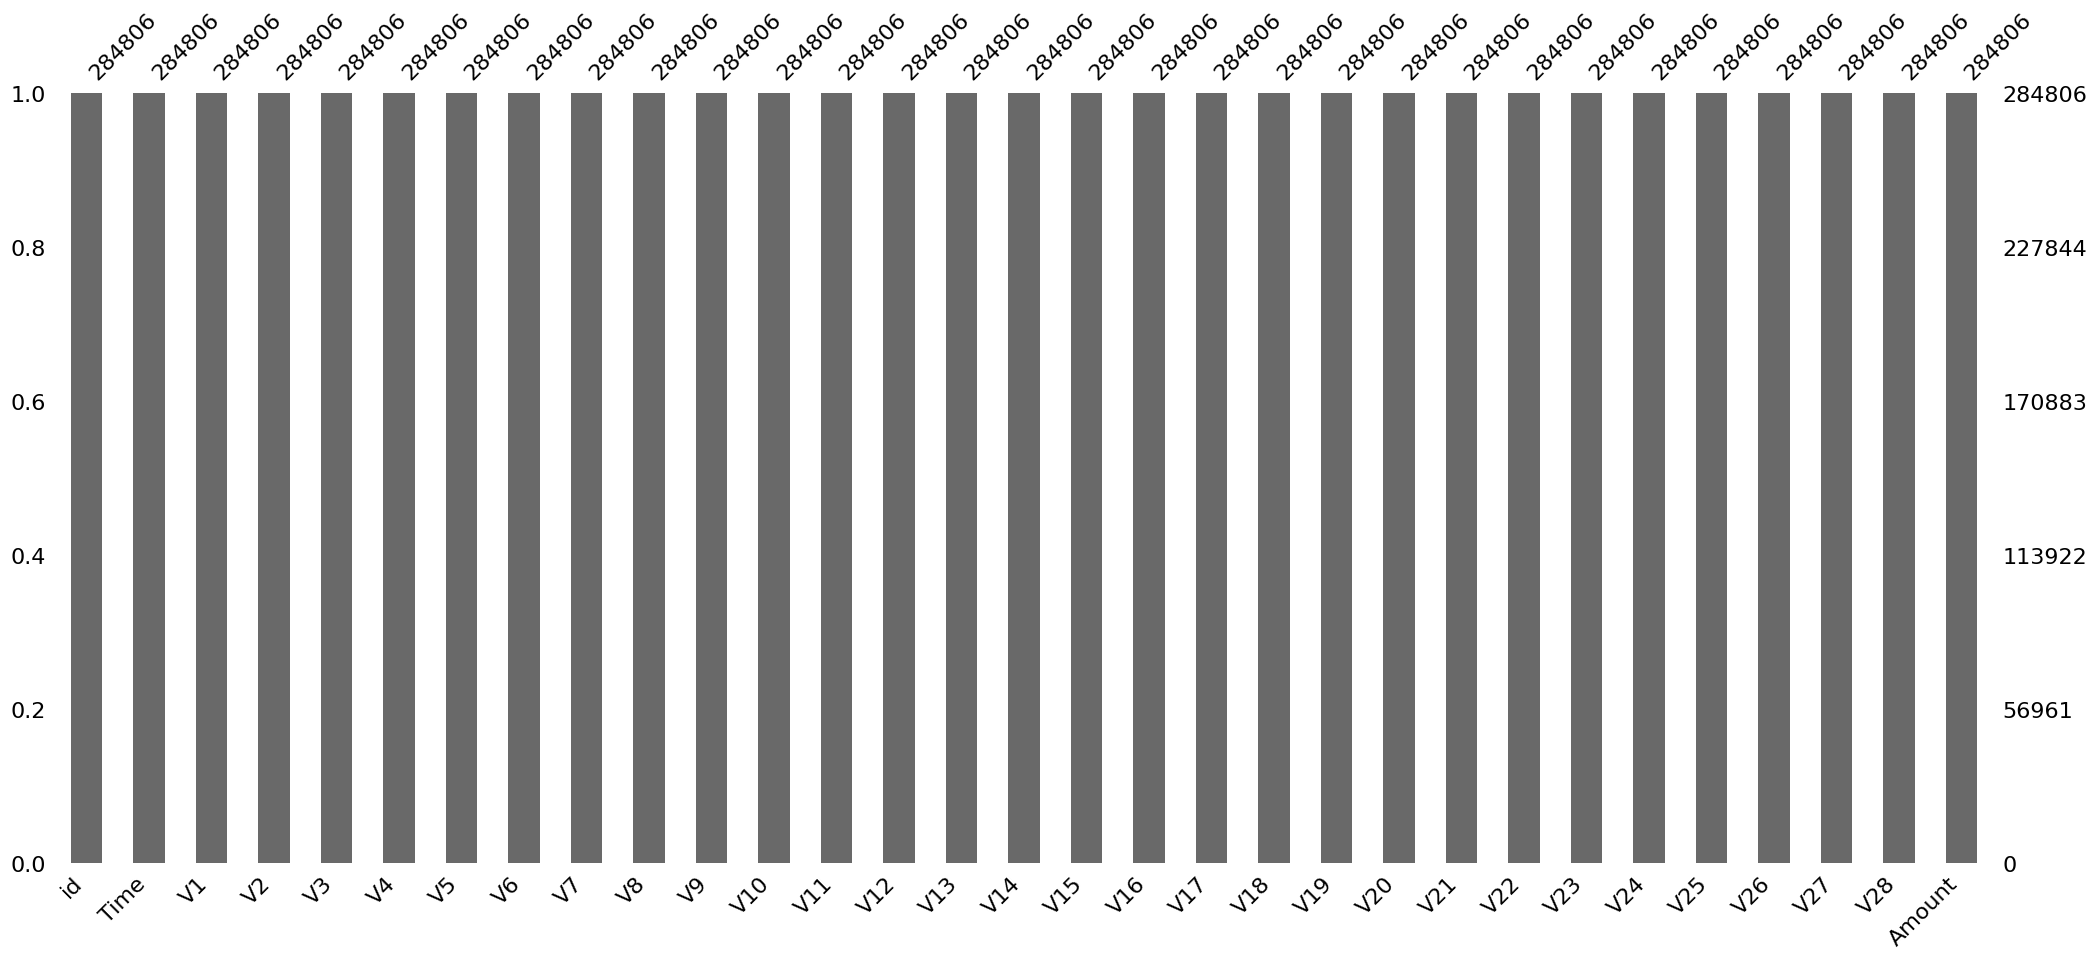

In [21]:
import missingno as msno
msno.bar(df = total_X)

## 전체 데이터 특징 요약
* 데이터 건수: 284,806건
* 결측치 비중: 0%
* 독립변수(X): 연속형 데이터
* 종속변수(y): 범주형 데이터

## 독립변수 상관관계 분석

In [22]:
corr = total_X.drop(['id','Time'], axis = 1).corr()
corr

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
V1,1.000000e+00,-1.098662e-07,4.435476e-07,-3.419079e-07,-8.691327e-09,-4.662442e-07,1.218936e-06,-3.319695e-07,4.231489e-07,-8.039051e-07,-9.746989e-07,-3.015686e-08,-1.807084e-07,-8.410574e-08,4.317967e-08,-3.302304e-07,-7.434654e-07,1.910058e-07,-3.008437e-07,4.749814e-07,3.398433e-07,8.473350e-07,5.769372e-07,1.388936e-08,-8.688328e-07,-1.622536e-06,-5.721833e-09,3.953878e-08,-0.227708
V2,-1.098662e-07,1.000000e+00,1.871369e-07,-1.442541e-07,-3.666952e-09,-1.967128e-07,5.142803e-07,-1.400610e-07,1.785305e-07,-3.391751e-07,-4.112346e-07,-1.272346e-08,-7.624256e-08,-3.548500e-08,1.821791e-08,-1.393273e-07,-3.136750e-07,8.058712e-08,-1.269288e-07,2.003991e-07,1.433830e-07,3.574986e-07,2.434152e-07,5.860053e-09,-3.665687e-07,-6.845632e-07,-2.414095e-09,1.668178e-08,-0.531409
V3,4.435476e-07,1.871369e-07,1.000000e+00,5.823773e-07,1.480408e-08,7.941614e-07,-2.076233e-06,5.654491e-07,-7.207564e-07,1.369305e-06,1.660221e-06,5.136668e-08,3.078036e-07,1.432587e-07,-7.354864e-08,5.624869e-07,1.266357e-06,-3.253433e-07,5.124320e-07,-8.090437e-07,-5.788606e-07,-1.443280e-06,-9.827065e-07,-2.365798e-08,1.479897e-06,2.763693e-06,9.746094e-09,-6.734705e-08,-0.210881
V4,-3.419079e-07,-1.442541e-07,5.823773e-07,1.000000e+00,-1.141170e-08,-6.121778e-07,1.600460e-06,-4.358754e-07,5.555937e-07,-1.055526e-06,-1.279778e-06,-3.959591e-08,-2.372698e-07,-1.104307e-07,5.669483e-08,-4.335919e-07,-9.761687e-07,2.507902e-07,-3.950072e-07,6.236498e-07,4.462136e-07,1.112549e-06,7.575175e-07,1.823671e-08,-1.140776e-06,-2.130387e-06,-7.512757e-09,5.191435e-08,0.098732
V5,-8.691327e-09,-3.666952e-09,1.480408e-08,-1.141170e-08,1.000000e+00,-1.556161e-08,4.068384e-08,-1.107999e-08,1.412324e-08,-2.683156e-08,-3.253207e-08,-1.006531e-09,-6.031418e-09,-2.807157e-09,1.441187e-09,-1.102194e-08,-2.481429e-08,6.375110e-09,-1.004112e-08,1.585323e-08,1.134279e-08,2.828110e-08,1.925616e-08,4.635776e-10,-2.899862e-08,-5.415463e-08,-1.909743e-10,1.319667e-09,-0.386356
V6,-4.662442e-07,-1.967128e-07,7.941614e-07,-6.121778e-07,-1.556161e-08,1.000000e+00,2.182475e-06,-5.943834e-07,7.576378e-07,-1.439373e-06,-1.745175e-06,-5.399513e-08,-3.235540e-07,-1.505893e-07,7.731216e-08,-5.912696e-07,-1.331157e-06,3.419912e-07,-5.386534e-07,8.504428e-07,6.084812e-07,1.517133e-06,1.032992e-06,2.486857e-08,-1.555624e-06,-2.905112e-06,-1.024481e-08,7.079323e-08,0.215982
V7,1.218936e-06,5.142803e-07,-2.076233e-06,1.600460e-06,4.068384e-08,2.182475e-06,1.000000e+00,1.553939e-06,-1.980747e-06,3.763055e-06,4.562536e-06,1.411633e-07,8.458905e-07,3.936964e-07,-2.021227e-07,1.545798e-06,3.480139e-06,-8.940922e-07,1.408240e-06,-2.223374e-06,-1.590796e-06,-3.966349e-06,-2.700625e-06,-6.501569e-08,4.066980e-06,7.595043e-06,2.678373e-08,-1.850798e-07,0.397310
V8,-3.319695e-07,-1.400610e-07,5.654491e-07,-4.358754e-07,-1.107999e-08,-5.943834e-07,1.553939e-06,1.000000e+00,5.394441e-07,-1.024845e-06,-1.242578e-06,-3.844496e-08,-2.303730e-07,-1.072208e-07,5.504686e-08,-4.209886e-07,-9.477941e-07,2.435004e-07,-3.835254e-07,6.055219e-07,4.332433e-07,1.080211e-06,7.354984e-07,1.770662e-08,-1.107617e-06,-2.068463e-06,-7.294381e-09,5.040534e-08,-0.103079
V9,4.231489e-07,1.785305e-07,-7.207564e-07,5.555937e-07,1.412324e-08,7.576378e-07,-1.980747e-06,5.394441e-07,1.000000e+00,1.306330e-06,1.583867e-06,4.900432e-08,2.936477e-07,1.366702e-07,-7.016614e-08,5.366181e-07,1.208117e-06,-3.103807e-07,4.888652e-07,-7.718357e-07,-5.522388e-07,-1.376903e-06,-9.375118e-07,-2.256995e-08,1.411837e-06,2.636590e-06,9.297869e-09,-6.424976e-08,-0.044246
V10,-8.039051e-07,-3.391751e-07,1.369305e-06,-1.055526e-06,-2.683156e-08,-1.439373e-06,3.763055e-06,-1.024845e-06,1.306330e-06,1.000000e+00,-3.009057e-06,-9.309921e-08,-5.578767e-07,-2.596483e-07,1.333028e-07,-1.019476e-06,-2.295200e-06,5.896663e-07,-9.287542e-07,1.466346e-06,1.049152e-06,2.615863e-06,1.781100e-06,4.287876e-08,-2.682230e-06,-5.009037e-06,-1.766424e-08,1.

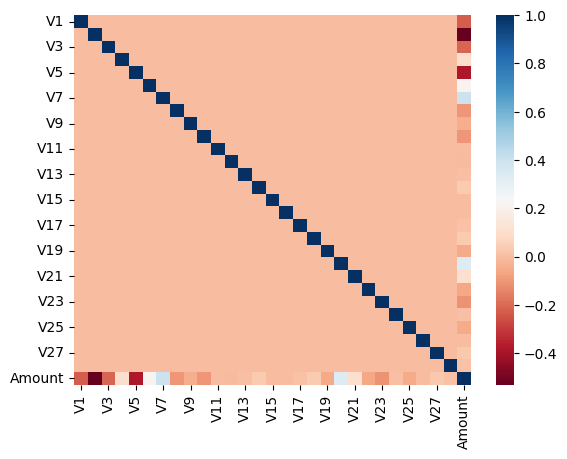

In [23]:
sns.heatmap(corr,
            cbar = True,
            cmap = 'RdBu'
           )
plt.show()

In [24]:
corr['Amount'].sort_values(ascending = False).head(5)

Amount    1.000000
V7        0.397310
V20       0.339403
V6        0.215982
V21       0.105998
Name: Amount, dtype: float64

## 상관관계 분석 결과
* 시각적으로 확인했을 때 Amount칼럼은 각 V1~V27변수들과 모종의 상관관계가 있다.
* Amount칼럼과 상대적으로 높은 상관관계를 보이는 칼럼은['V7','V20','V21']이다.
* 독립변수 V1~V27 간에는 특별히 다중공선성의 문제는 발견되지 않는다. 

## V1~V28 분산 시각화

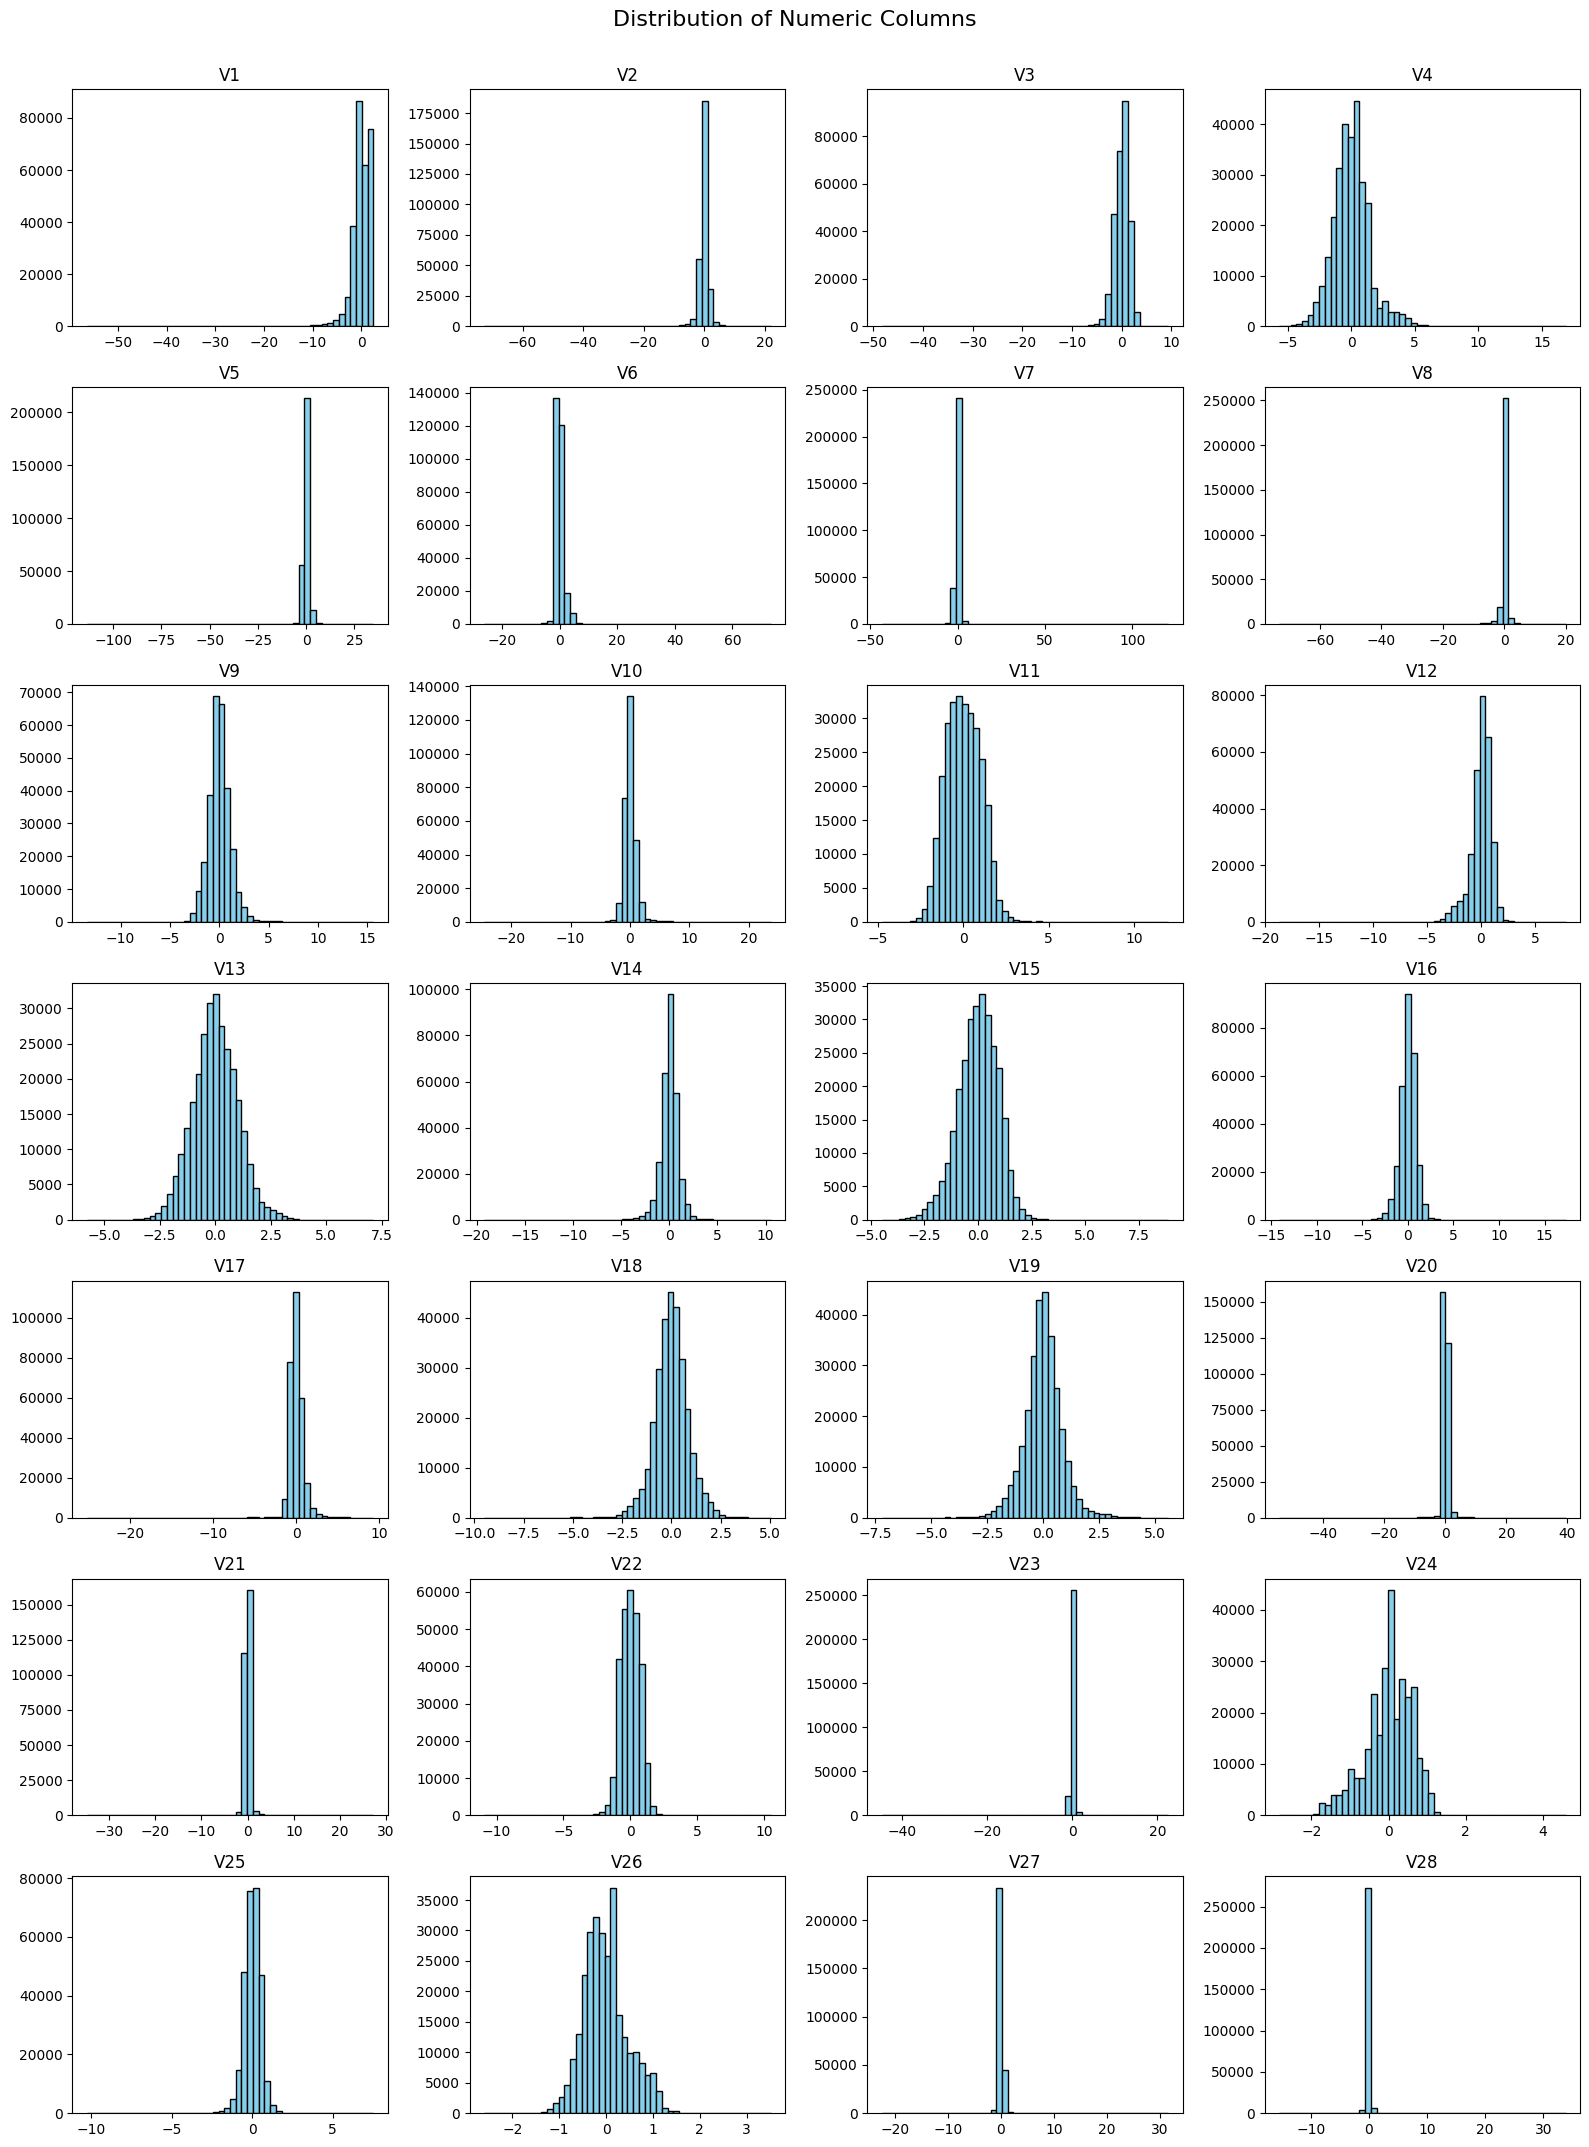

In [25]:
import math

# 숫자형 칼럼만 선택
df = total_X.drop(['id','Time','Amount'], axis = 1)
numeric_cols = df.columns
n = len(numeric_cols)

cols = 4  # 한 줄에 4개
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    plt.hist(df[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Distribution of Numeric Columns", fontsize=16, y=1.02)
plt.show()

## 칼럼 Amount 분석

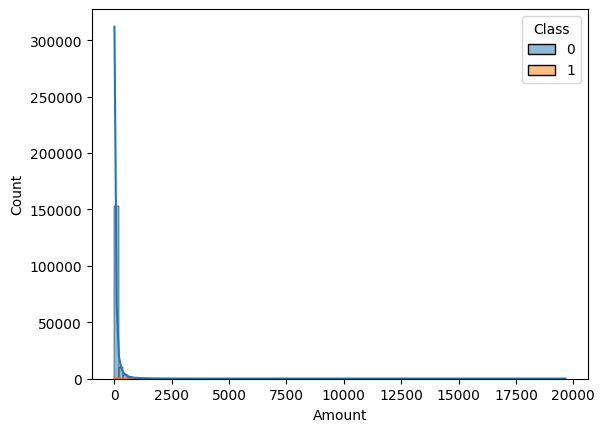

In [26]:
sns.histplot(x='Amount', data=train, bins=100, kde=True, hue = 'Class')
plt.show()

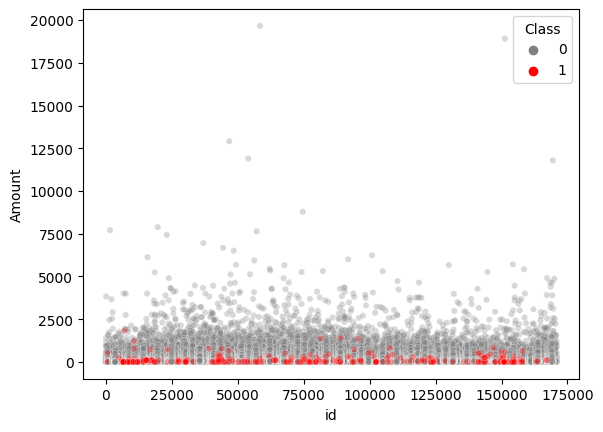

In [27]:
df_sorted = train.sort_values(by = 'Class')
sns.scatterplot(
                x = 'id',
                y = 'Amount',
                hue = 'Class', 
                data = df_sorted,
                alpha = 0.3,                  
                palette = {0: 'gray', 1: 'red'}, 
                s = 20                     
                )
plt.show()

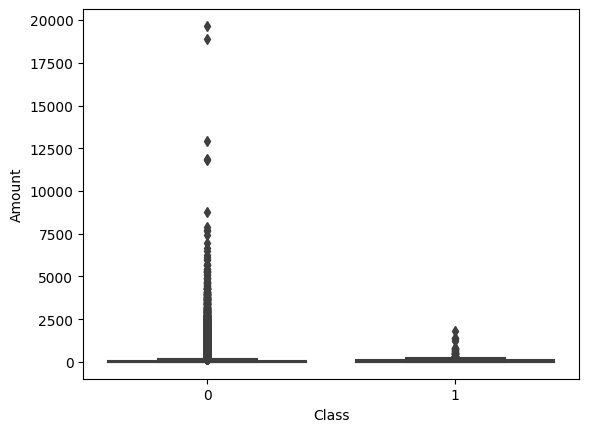

In [28]:
sns.boxplot(
            x = 'Class',
            y = 'Amount',
            data = train
            )
plt.show()

In [29]:
train['Amount'].describe()

count    170883.000000
mean         87.336704
std         245.954429
min           0.000000
25%           5.480000
50%          21.890000
75%          76.720000
max       19656.530000
Name: Amount, dtype: float64

In [30]:
train['Amount'].quantile([0.2, 0.4, 0.6, 0.8])

0.2     3.514
0.4    12.990
0.6    36.790
0.8    99.990
Name: Amount, dtype: float64

### Amount 칼럼 분석

* 다른 연속형 칼럼과는 다르게 비정규화된 형식을 띄고 있음.
* 다른 칼럼과 유사하게 정규화 처리를 거칠 필요가 있음.
* 카드 사용금액이 100불 이하인 데이터가 주를 이루고 있음.
* 일부 고객은 카드 사용금액이 주류 고객보다 월등하게 많음.
* 선형 알고리즘 적용 시엔 해당 칼럼에서 이상치를 제거할 필요가 있음. 

 # 4. Function Definition

In [31]:
# 평가 함수

def get_clf_eval(y_test, pred, pred_proba=None):
    
    # input: test data, model prediction
    # output: confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba) # 최종평가지표
    
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision: .4f}, 재현율: {recall: .4f}, f1스코어: {f1:.4f}, roc-auc: {roc_auc:.4f}")

In [32]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    
    # input: fractional train data set
    # output: evaluation index prints
    
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1] #id 제외한 나머지 X
    get_clf_eval(tgt_test, pred, pred_proba)

# 5. Preprocess

* Amount: 스케일링 (Scaling), 이상치 처리
* Time: 제거
* id: 제거


## Outliar 처리함수 정의

In [33]:
def get_outlier(df=None, column=None, weight=1.5, option='index'):

    # input: train data, column name, weight(optional)
    # output: index of Outliars of Fraud records

    fraud = df[df["Class"] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25) # 1분위값
    quantile_75 = np.percentile(fraud.values, 75) # 3분위값
    
    iqr = quantile_75 - quantile_25 # Interquartile Range
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    normal_range = ~(fraud < lowest_val) | (fraud > highest_val) # About 99.3% in Normal Distribution
    
    outlier_index = fraud[~normal_range].index
    if(option == 'index'):
        return outlier_index
    else:
        return lowest_val,highest_val

In [34]:
outlier_index = get_outlier(df = train, column = 'Amount', weight = 1.5) # Not Normalized
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([], dtype='int64')


* Fraud 데이터 중에는 Amount 기준으로 Outliar에 해당되는 레코드가 없음.

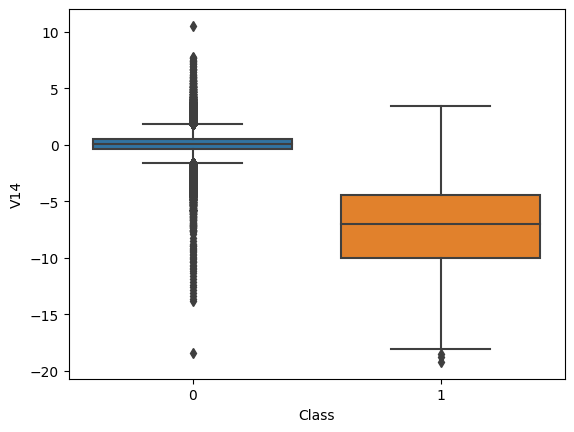

In [35]:
sns.boxplot(
            x = 'Class',
            y = 'V14',
            data = train
            )
plt.show()

### V14칼럼 4분위값 분석

* Fraud 데이터와 일반 고객 데이터의 V14 분포범위가 다르게 나타남.
* Fraud 데이터 중에서 V14값이 비교적으로 낮은 Outliar가 관측됨.

In [36]:
outlier_index = get_outlier(df = train, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035], dtype='int64')


* Fraud 데이터 중에는 V14 기준으로 Outliar에 해당되는 레코드가 3건 존재.

## 전처리 이전 모델 성능 측정

### HyperParameter Default Setting

In [37]:
lr_clf = LogisticRegression(max_iter = 1000)
lgbm_clf = LGBMClassifier(n_estimators = 1000, 
                          num_leaves = 64, 
                          n_jobs = -1, 
                          boost_from_average = False,
                          verbose = -1,
                          random_state = 123
                         )

### Train Data Slicing

In [38]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수

def get_train_test_dataset(df = train):
    
    # input: Train Data Set
    # output: X_train, X_test, y_train, y_test

    # df_copy = get_preprocessed_df(df) # 필요할 때 활성화
    df_copy = df
    X_features = df_copy.iloc[:, :-1] # X : Columns except target column
    y_target = df_copy.iloc[:, -1] # Target : Class
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size = 0.3, # train:test = 7:3
                                                        random_state = 0, 
                                                        stratify = y_target
                                                       )
    
    return X_train, X_test, y_train, y_test

In [39]:
# Train Data set 전처리 및 Slicing
X_train, X_test, y_train, y_test = get_train_test_dataset()
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[51145    12]
 [   43    65]]
정확도: 0.9989, 정밀도:  0.8442, 재현율:  0.6019, f1스코어: 0.7027, roc-auc: 0.9521
### LightGBM 예측 성능 ###
오차 행렬
[[51151     6]
 [   17    91]]
정확도: 0.9996, 정밀도:  0.9381, 재현율:  0.8426, f1스코어: 0.8878, roc-auc: 0.9729


### 전처리 이전 모델링 결과 분석

* 정확도 기준으로 두 모델 모두 99.9% 이상의 예측을 정확히 수행해냄.
* roc-auc 점수 기준으로 LightGBM 모델의 성능이 비교적 우수함.

## 전처리 이후 모델링 결과 분석

## 전처리 함수 정의

* 불필요 칼럼 제거: Amount, Time
* 스케일링: Amount 칼럼 로그 스케일링 > V29
* 이상치 제거: V14 칼럼 기준


> np.log1p(x): log1p(x)=log e• (1+x)


In [40]:
def get_preprocessed_df(df = None, train = True):
    
    # input: Datafram with cloumn ["Amount","Time"]
    # output: Datafram with log_scaled column "Amount", without "Time"

    df_copy = df.copy()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "V29", amount_n) # V29 : Amount_Scaled
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    
    outlier_index = get_outlier(df = df_copy, column = "V14", weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True) #V14 Outliar 제거
    
    return df_copy

### Prepross and slice again

In [41]:
train_preprocessed = get_preprocessed_df(train)

In [42]:
train_preprocessed.columns

Index(['V29', 'id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class'],
      dtype='object')

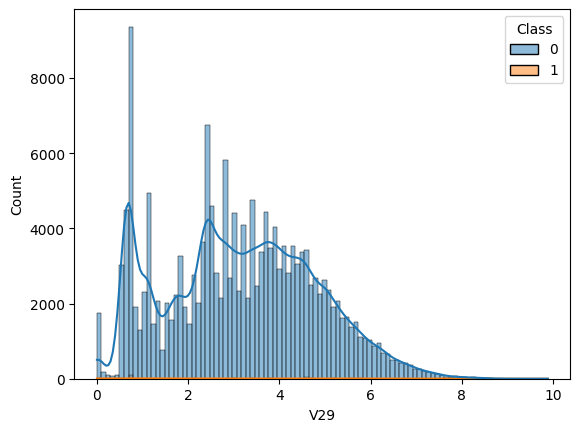

In [43]:
sns.histplot(x='V29', data=train_preprocessed, bins=100, kde=True, hue = 'Class')
plt.show()

Amount 칼럼 스케일링 결과: 정규분포에 가까운 분포형태를 띄게 됨.

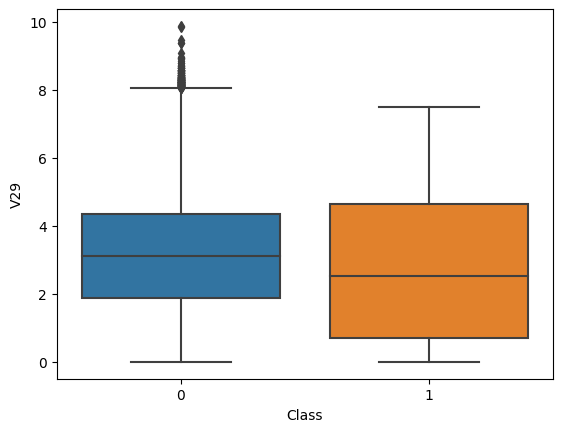

In [44]:
sns.boxplot(
            x = 'Class',
            y = 'V29',
            data = train_preprocessed
            )
plt.show()

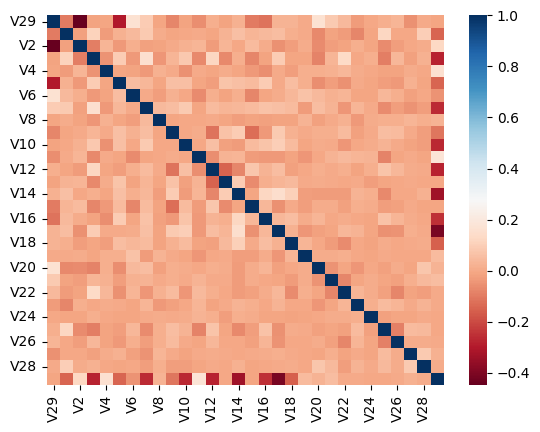

In [45]:
corr = train_preprocessed.drop('id', axis = 1).corr()
sns.heatmap(corr,cbar = True,cmap='RdBu')
plt.show()

## Medel Evaluation after preprossing

In [46]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df = train_preprocessed)

In [47]:

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[51146    11]
 [   42    65]]
정확도: 0.9990, 정밀도:  0.8553, 재현율:  0.6075, f1스코어: 0.7104, roc-auc: 0.9376
### LightGBM 예측 성능 ###
오차 행렬
[[51153     4]
 [   18    89]]
정확도: 0.9996, 정밀도:  0.9570, 재현율:  0.8318, f1스코어: 0.8900, roc-auc: 0.9769


### 전처리 이후 모델링 결과 분석

* 로지스틱 회귀 성능: 정확도 -0.0002%p, roc-auc: -0072%p
* LightGBM 예측 성능: 정확도 0, roc-auc: 0

# 6. SMOTE Over Sampling

* 지도학습 알고리즘 극도로 불균형한 레이블 값 분포의 문제 해결을 위한 학습 데이터셋 확보 방안
* Over Sampling: 적은 데이트 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법.
    * SMOTE: K 최근접 이웃(KNN)을 찾아서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성하는 기법

In [48]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print()
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.790998
1     0.209002
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Class
0    99.791277
1     0.208723
Name: count, dtype: float64


* 기존의 Fraud 데이터 비중은 0.21% 수준으로 학습할 수 있는 데이터의 양이 매우 적은 수준

In [49]:
smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [50]:
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("\nSMOTE 적용 후 학습용 피처/레이블 데이터 세트: ", X_train_over.shape, y_train_over.shape)
print("\nSMOTE 적용 후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts(normalize=True))

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (119616, 30) (119616,)

SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (238732, 30) (238732,)

SMOTE 적용 후 레이블 값 분포: 
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [51]:
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, 
                     ftr_train = X_train_over, 
                     ftr_test = X_test, 
                     tgt_train = y_train_over, 
                     tgt_test = y_test
                    )

오차 행렬
[[50567   590]
 [   14    93]]
정확도: 0.9882, 정밀도:  0.1362, 재현율:  0.8692, f1스코어: 0.2354, roc-auc: 0.9725


## SMOTE Over-sampling 결과 분석

* Over-sampling 적용 결과 로지스틱 회귀 알고리즘의 roc-auc 스코어 4%p 증가
* 반면, 정확도는 Over-sampling 적용 이전에 비해 1%p 정도 감소.
* 신규 증식한 데이터 셋은 Train data set의 특징을 바탕으로 한 것이다.
* 결론적으로 오버샘플링은 Train data에 적합하게 학습을 진행한다. 

# 7. Modeling

## Model Selection

* 선택기준: 다중 연속형 독립변수를 통해 범주형 종속변수를 효율적으로 분류할 수 있는가
* 모델후보: LogisticRegression, LGBMClassifier
* model 변수에 실험 대상 모델을 적용하여 실험 진행.

## LogisticRegression

* Learning train data set and evaluate the model
* Learning over-sampled data set and evaluate the model

In [52]:
get_model_train_eval(model = lr_clf, 
                     ftr_train = X_train, 
                     ftr_test = X_test, 
                     tgt_train = y_train, 
                     tgt_test = y_test
                    )

오차 행렬
[[51146    11]
 [   42    65]]
정확도: 0.9990, 정밀도:  0.8553, 재현율:  0.6075, f1스코어: 0.7104, roc-auc: 0.9376


In [53]:
get_model_train_eval(model = lr_clf, 
                     ftr_train = X_train_over, 
                     ftr_test = X_test, 
                     tgt_train = y_train_over, 
                     tgt_test = y_test
                    )

오차 행렬
[[50567   590]
 [   14    93]]
정확도: 0.9882, 정밀도:  0.1362, 재현율:  0.8692, f1스코어: 0.2354, roc-auc: 0.9725


### 로지스틱 회귀분석 성능분석

* 정확도 측면에서 train 데이터 셋에 적용한 경우 성능이 보다 우수
* ROC_AUC 측면에서 over_sampled 데이터 셋에 적용한 경우 성능이 보다 4%p 우수
* 그러나 여전히 Train Data에 적합한 모델링 기법이라는 한계를 지님.
* Train data set과 Test 데이터 셋의 Class 분균형 해소여부 의문.

## LGBMClassifier

* Learning train data set and evaluate the model
* Learning over-sampled data set and evaluate the model

In [54]:
get_model_train_eval(model = lgbm_clf, 
                     ftr_train = X_train, 
                     ftr_test = X_test, 
                     tgt_train = y_train, 
                     tgt_test = y_test)

오차 행렬
[[51153     4]
 [   18    89]]
정확도: 0.9996, 정밀도:  0.9570, 재현율:  0.8318, f1스코어: 0.8900, roc-auc: 0.9769


In [55]:
get_model_train_eval(model = lgbm_clf, 
                     ftr_train=X_train_over, 
                     ftr_test=X_test, 
                     tgt_train=y_train_over, 
                     tgt_test=y_test
                    )

오차 행렬
[[51144    13]
 [   16    91]]
정확도: 0.9994, 정밀도:  0.8750, 재현율:  0.8505, f1스코어: 0.8626, roc-auc: 0.9821


### LGBMClassifier 성능분석

* 정확도 측면에서 train 데이터 셋에 적용한 경우 성능이 거의 유사.
* ROC_AUC 측면에서 over_sampled 데이터 셋에 적용한 경우 성능이 소폭 증가.
* 그러나 여전히 Train Data에 적합한 모델링 기법이라는 한계를 지님.
* Train data set과 Test 데이터 셋의 Class 분균형 해소여부 의문.

# 8.Prediction Submission

## Test data prepross

In [56]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,-2.277774,0.310404,-1.211770,-0.805137,-0.503570,1.154627,0.260146,-2.558533,0.876103,0.902372,0.422115,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,0.529802,0.776728,-0.864413,0.060070,-1.102005,-1.195983,-1.860611,-1.959586,0.448597,2.480298,0.527285,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,-0.648266,0.376802,-0.046308,0.167851,0.095213,0.621540,0.065680,-0.081217,-0.895254,1.031398,0.843741,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,-0.041604,-0.694289,-0.806051,0.277925,0.343193,-0.268240,-0.927519,0.153715,-0.885167,-1.040416,-1.133255,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,-0.634128,0.975375,0.226406,0.744480,0.852910,0.083724,-0.606380,-1.144119,-0.580166,1.559673,-0.343759,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


In [57]:
test.V14.describe()

count    113923.000000
mean         -0.123239
std           0.914506
min         -14.266836
25%          -0.593098
50%          -0.021141
75%           0.441543
max           6.894068
Name: V14, dtype: float64

In [58]:
normal_Amount = get_outlier(df = train, column = 'Amount', weight = 1.5, option = 'range')
normal_Amount
# test[(test['V14'] < normal_Amount[0]) | (test['V14'] > normal_Amount[1])]

(-153.51125, 258.51874999999995)

## 결측치 분석
* test 데이터는 train 데이터에서 설정한 범주 밖의 레코드가 존재하지 않는다.

In [59]:
test["V29"] = np.log1p(test["Amount"])

In [60]:
test.drop(["Time", "Amount"], axis=1, inplace=True)

In [61]:
test.columns

Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29'],
      dtype='object')

In [62]:
test = test[[test.columns[-1]] + list(test.columns[:-1])]
test.columns

Index(['V29', 'id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

## Final Prediction by Logistic Regression Model

In [63]:
lr_pred = lr_clf.predict

In [64]:
test["Class"] = lr_pred

In [65]:
test.Class.value_counts() / len(test)

Class
<bound method LinearClassifierMixin.predict of LogisticRegression(max_iter=1000)>    1.0
Name: count, dtype: float64

In [66]:
for column in train_preprocessed.columns:
    if column not in test.columns:
        print(column)

In [67]:
total = pd.concat([test,train_preprocessed], axis = 0)

## Check distribution of V14 column

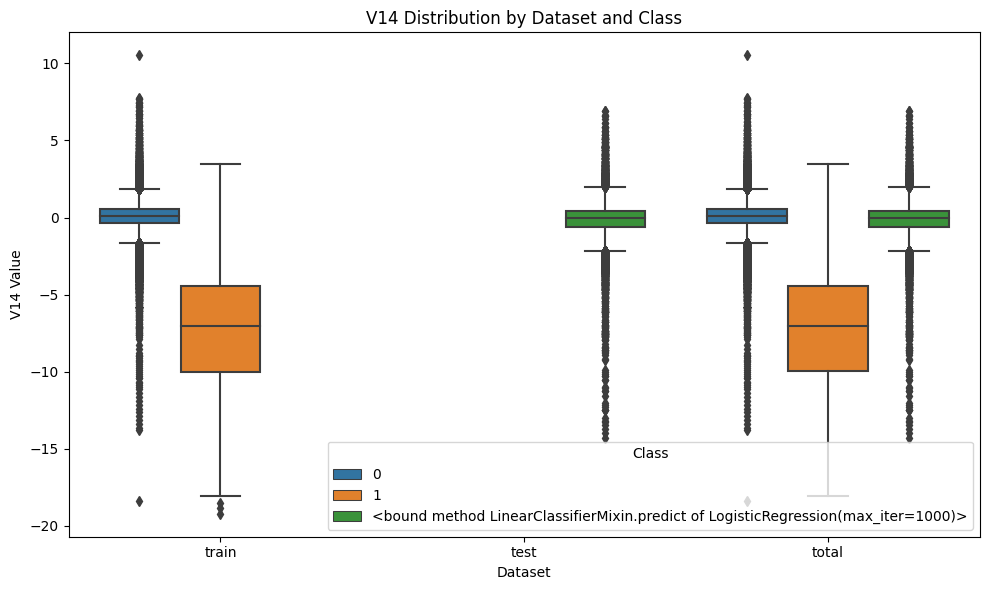

In [68]:
# source 이름 부여
train['source'] = 'train'
test['source'] = 'test'
total['source'] = 'total'

# 필요한 칼럼만 남기고 병합
df_all = pd.concat([
    train[['V14', 'Class', 'source']],
    test[['V14', 'Class', 'source']],
    total[['V14', 'Class', 'source']]
], ignore_index=True)

# 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='V14', hue='Class', data=df_all, whis=1.5) #weight = 1.5 적용

plt.title('V14 Distribution by Dataset and Class')
plt.xlabel('Dataset')
plt.ylabel('V14 Value')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

## Save result in submission file 

In [69]:
submission = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/sample_submission.csv")

In [70]:
del submission["Class"]

In [71]:
submission = submission.merge(test[["id", "Class"]], on="id")

In [72]:
submission.to_csv("./submission.csv", index=False)